In [1]:
import numpy as np
from scipy.sparse import csr_matrix,csc_matrix,save_npz,load_npz,coo_matrix, vstack
import sys
from tqdm import tqdm
import h5py
import os
import matplotlib.pyplot as plt

# Test Datasets

In [2]:
HDDFolder = '/home/invites/jmorlot/HDD/'
data_path = HDDFolder + '/Datasets/ATAC_Hemato_Buenrostro/Raw/'
matrixSp = load_npz(data_path+'matrix_scATACseqSparse.npz')
matrixSp = matrixSp.tocsr()
namesCT = np.load(data_path+'names.npy')
labels = np.load(data_path+'labels.npy')

In [3]:
s = np.sum(matrixSp.tocsc(),axis=0)
idx1 = np.where(s>0)[1]
print len(idx1)
matrix = matrixSp[:,idx1].toarray()

488736


In [4]:
idx = np.argsort(labels)
matrix = matrix[idx,:]
labels = labels[idx]

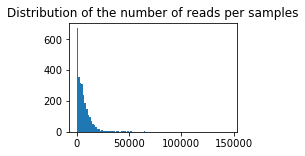

In [5]:
plt.figure(figsize=(3,2))
plt.hist(matrix.sum(axis=1),100)
plt.title('Distribution of the number of reads per samples')
#plt.savefig('histogram.png',dpi=300)
plt.show()

In [6]:
matrix.sum(axis=1).max()

145436.0

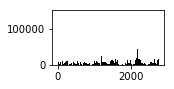

In [7]:
plt.figure(figsize=(2,1))
plt.bar(np.arange(matrix.shape[0]),matrix.sum(axis=1),1,color='k')
#plt.savefig('plot_sum.png',dpi=300)
plt.show()

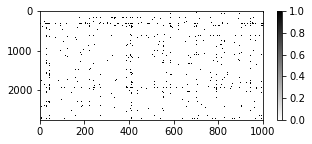

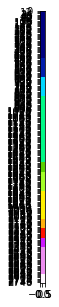

In [8]:
plt.figure(figsize=(5,2))
plt.imshow(matrix[idx,1100:2100],aspect='auto',cmap='gray_r')
plt.colorbar()
plt.savefig('ATAC_matrix_large.png',dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(labels[:,None],aspect=0.02,cmap='gist_ncar')
plt.yticks(np.arange(0,matrix.shape[0]+1,labels.max()+1))
plt.savefig('ATAC_colorbar.png',dpi=300)
plt.show()


# Remove samples for efficiency

In [9]:
#idx = np.hstack([np.where(labels==l)[0][:50] for l in np.unique(labels)])
#labels = labels[idx]
#matrix = matrix[idx]

# NGS Quality Tester

In [60]:
sys.path.append('../')
import QualityTester as QT
import QualityMesures as QM
reload(QT)

<module 'QualityTester' from '../QualityTester.py'>

In [11]:
qt = QT.QualityTester()

In [61]:
reload(QT)
reload(QM)
qt2 = QT.QualityTester()
qt2.__dict__ = qt.__dict__ 
qt = QT.QualityTester()
qt.__dict__  = qt2.__dict__
del qt2

Remove outliers defined by anomalous number of reads


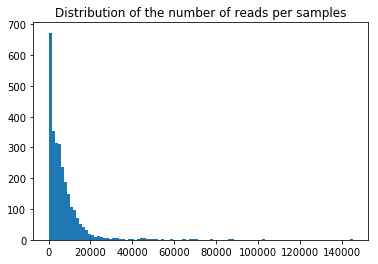

Lower threshold = 611
Upper threshold = 20158
Number of removed samples = 557 / 2755

Testing all distances:

None
	Chebyshev
	Sokal Michener
	Pearson
	Mutual Information
	Dice
	Canberra
	Jaccard
	Squared Euclidean
	Bray Curtis
	Spearman
	Yule
	Euclidean
	Cosine
	City Block
	Hamming
	L2
	Rogers Tanimoto
	Sokal Sneath
	Russell Rao

PCA
	City Block
	Cosine
	Euclidean
	L2
	Bray Curtis
	Canberra
	Pearson
	Squared Euclidean
	Mutual Information
	Chebyshev
	Spearman
Get optimal PCA-Distance-Kernel
Optimal (PCA,Distance,Kernel) = ('PCA', 'Spearman', 'None')


In [34]:
qt.get_optimal_distance(matrix=matrix,labels=labels,
                        threshold = [0.05, 0.95])

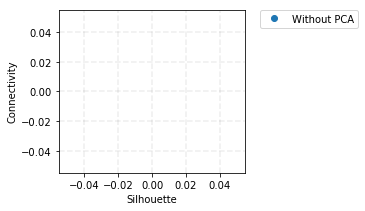

In [24]:
qt.displayNamesScatter(Suffix='_scATACCont',ImgSize=3,numdisplay=8,dispNoPCA=True,dispPCA=False)

In [54]:
qt.SortedPDKkey['Sum'] = np.array([key for key in qt.SortedPDKkey['Sum'] if key not in ['PCA-Cosine-None','PCA-Pearson-None']])

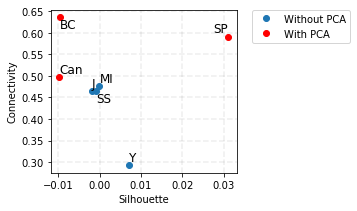

In [62]:
qt.displayNamesScatter(Suffix='_scATACCont_PCA',ImgSize=3,numdisplay=8,dispNoPCA=True,dispPCA=True)

In [307]:
rank={}
k,c = np.unique(np.hstack([qt.Res[Ikey].keys() for Ikey in qt.Res]),return_counts=True)
qt.PDKkeys = k[c>=2] #Keep keys present only in the all indexes

qt.PDKrank = {}

for Ikey in ['Silhouette','Connectivity']:
    values = np.hstack([qt.Res[Ikey][PDKkey] for PDKkey in qt.PDKkeys])
    idx = np.argsort(values)
    idx = idx[~np.isnan(values[idx])]
    # if Ikey=='Silhouette': idx = idx[::-1]
    idx = idx[::-1]
    qt.PDKrank[Ikey] = np.argsort(idx)

In [311]:
qt.PDKrank['Sum'] = np.zeros(len(qt.PDKkeys))
for Ikey in ['Silhouette','Connectivity']:
    qt.PDKrank['Sum'] += qt.PDKrank[Ikey]

qt.SortedPDKkey = {}
qt.SortedPDKkey['Sum'] = qt.PDKkeys[np.argsort(qt.PDKrank['Sum'])]

for Ikey in ['Silhouette','Connectivity']:
    qt.SortedPDKkey[Ikey] = qt.PDKkeys[np.argsort(qt.PDKrank[Ikey])]

In [312]:
qt.Res['Silhouette']

{'None-Bray Curtis-None': -0.0036647877281053049,
 'None-Canberra-None': -0.20608512039808854,
 'None-Chebyshev-None': 0.0,
 'None-City Block-None': -0.20608512039808854,
 'None-Cosine-None': -0.0040912035938019701,
 'None-Dice-None': -0.0036647877281053049,
 'None-Euclidean-None': -0.1084921258724291,
 'None-Hamming-None': -0.20608512039808854,
 'None-Jaccard-None': -0.0018651547392172835,
 'None-L2-None': -0.1084921258724291,
 'None-Mutual Information-None': -4.6238560569330572e-05,
 'None-Pearson-None': -0.0024846159418413266,
 'None-Rogers Tanimoto-None': -0.20205787154518398,
 'None-Russell Rao-None': -0.00029841432054449903,
 'None-Sokal Michener-None': -0.20205787154518398,
 'None-Sokal Sneath-None': -0.00093938174460420998,
 'None-Spearman-None': -0.0024846159418413266,
 'None-Yule-None': 0.0070080129042104271,
 'PCA-Bray Curtis-None': -0.0095400715492359473,
 'PCA-Canberra-None': -0.0097932211547565925,
 'PCA-Chebyshev-None': -0.22024379819021031,
 'PCA-City Block-None': -0.28

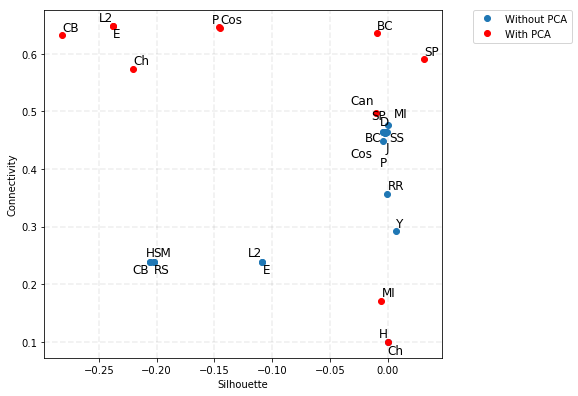

In [321]:
qt.displayNamesScatter(Suffix='_scATACCont_PCA_all',ImgSize=6.4,numdisplay=-1,dispNoPCA=True,dispPCA=True)

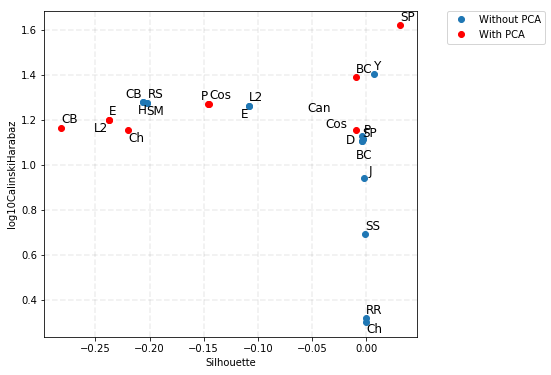

In [235]:
qt.displayNamesScatter(Suffix='_scATACCont_Cal_PCA_all',ImgSize=6,numdisplay=-1,dispNoPCA=True,dispPCA=True,IkeyY='log10CalinskiHarabaz')

In [30]:
qt.Distmat.keys()

['None-Sokal Michener-None',
 'None-City Block-None',
 'None-Spearman-None',
 'None-L2-None',
 'None-Jaccard-None',
 'PCA-Cosine-None',
 'PCA-L2-None',
 'None-Chebyshev-None',
 'None-Yule-None',
 'PCA-Canberra-None',
 'PCA-Spearman-None',
 'PCA-Bray Curtis-None',
 'None-Euclidean-None',
 'None-Cosine-None',
 'PCA-Chebyshev-None',
 'None-Squared Euclidean-None',
 'None-Mutual Information-None',
 'PCA-Pearson-None',
 'None-Russell Rao-None',
 'None-Canberra-None',
 'None-Pearson-None',
 'PCA-Euclidean-None',
 'None-Hamming-None',
 'PCA-Mutual Information-None',
 'None-Dice-None',
 'PCA-Squared Euclidean-None',
 'None-Rogers Tanimoto-None',
 'None-Bray Curtis-None',
 'PCA-City Block-None',
 'None-Sokal Sneath-None']

In [28]:
qt.clust_index_filt_threshold={Ikey:{} for Ikey in qt.AllInternIndex.keys()}
for Tkey in qt.Distmat.keys():
    print Tkey
    for Ikey in qt.AllInternIndex.keys():
        #Compute the clustering index score
        if Ikey!='log10CalinskiHarabaz':
            print '\t' + Ikey
            try:
                qt.Res[Ikey][Tkey] = qt.AllInternIndex[Ikey](qt.Distmat[Tkey],qt.labels)
                qt.clust_index_filt_evol[Ikey][Tkey],qt.clust_index_filt_score[Ikey][Tkey],qt.clust_index_filt_threshold[Ikey][Tkey] = qt.ClustIndexFilt(qt.Distmat[Tkey],qt.labels,Ikey)            
                print qt.clust_index_filt_score[Ikey][Tkey],qt.clust_index_filt_threshold[Ikey][Tkey]
            except Exception as e:
                print(e)
                continue

None-Sokal Michener-None
	Connectivity
0.3198555315186057 2088
	Silhouette
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
0.4137652542272796 2088
None-City Block-None
	Connectivity
0.3121471666951932 2088
	Silhouette
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_sa

../QualityMesures.py:23: RuntimeWarning: invalid value encountered in divide
  SilZ = (SilMat - m)/s


index 0 is out of bounds for axis 0 with size 0
	Silhouette
index 0 is out of bounds for axis 0 with size 0
None-Yule-None
	Connectivity
0.50129543564535 1050
	Silhouette
0.5454523643088212 1039
PCA-Canberra-None
	Connectivity
0.7252097590862113 1520
	Silhouette
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
0.5094348218949586 1519
PCA-Spearman-None
	Connectivity
0.8465076230059345 942
	Silhouette
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
0.5697355895077049 940
PCA-Bray Curtis-None
	Connectivity
0.8474328634285732 1239
	Silhouette
0.5551708289843108 1244
None-Euclidean-None
	Connectivity
0.32103531048490297 2088
	Silhouette
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 1. Valid va

In [239]:
qt.WriteClustIndexFiltScore(Suffix='_scATAC')

Connectivity
PCA-Bray Curtis-None 0.847754521793 1237
PCA-Spearman-None 0.846213916963 945
PCA-Cosine-None 0.833192784267 1586
PCA-Pearson-None 0.830948945605 1587
PCA-L2-None 0.783081789619 1910
PCA-Euclidean-None 0.782469104785 1887
PCA-City Block-None 0.743008213331 1974
PCA-Squared Euclidean-None 0.728961087309 1990
PCA-Canberra-None 0.724303170324 1504
PCA-Chebyshev-None 0.722609489487 1928
None-Pearson-None 0.699288138149 1421
None-Spearman-None 0.698830394913 1488
None-Mutual Information-None 0.694951081859 1231
None-Cosine-None 0.688158521253 1649
None-Dice-None 0.659313979106 1547
None-Jaccard-None 0.65852096539 1544
None-Sokal Sneath-None 0.657725584904 1534
None-Bray Curtis-None 0.655377499883 1560
None-Russell Rao-None 0.609165335827 2001
None-Yule-None 0.500073700147 1025
None-Canberra-None 0.326015789467 2088
None-Sokal Michener-None 0.324520628913 2088
None-Euclidean-None 0.32057437573 2088
None-City Block-None 0.319361748284 2088
None-L2-None 0.317573713746 2088
None-Ha

KeyError: 'None-Sokal Michener-None'

In [268]:
qt.WriteClustIndexFiltScore(Suffix='_scATAC')

Connectivity
PCA-Bray Curtis-None 0.847754521793 1237
PCA-Spearman-None 0.846213916963 945
PCA-Cosine-None 0.833192784267 1586
PCA-Pearson-None 0.830948945605 1587
PCA-L2-None 0.783081789619 1910
PCA-Euclidean-None 0.782469104785 1887
PCA-City Block-None 0.743008213331 1974
PCA-Squared Euclidean-None 0.728961087309 1990
PCA-Canberra-None 0.724303170324 1504
PCA-Chebyshev-None 0.722609489487 1928
None-Pearson-None 0.699288138149 1421
None-Spearman-None 0.698830394913 1488
None-Mutual Information-None 0.694951081859 1231
None-Cosine-None 0.688158521253 1649
None-Dice-None 0.659313979106 1547
None-Jaccard-None 0.65852096539 1544
None-Sokal Sneath-None 0.657725584904 1534
None-Bray Curtis-None 0.655377499883 1560
None-Russell Rao-None 0.609165335827 2001
None-Yule-None 0.500073700147 1025
None-Canberra-None 0.326015789467 2088
None-Sokal Michener-None 0.324520628913 2088
None-Euclidean-None 0.32057437573 2088
None-City Block-None 0.319361748284 2088
None-L2-None 0.317573713746 2088
None-Ha

KeyError: 'None-Sokal Michener-None'

In [187]:
idx = np.argsort(qt.clust_index_filt_score['Silhouette'].values())[::-1]
keys = np.array(qt.clust_index_filt_score['Silhouette'].keys())[idx]
f = file('Filt_index__scATACCont.txt','w')
f.write('\t'.join(['Distance','Filtered Clustering Index','Number profiles removed at Zscore Silhouette 1.65'])+'\n')
for key in keys:
    print key,qt.clust_index_filt_score['Silhouette'][key],qt.clust_index_filt_threshold['Silhouette'][key]
    f.write('\t'.join([key,str(qt.clust_index_filt_score['Silhouette'][key]),str(qt.clust_index_filt_threshold['Silhouette'][key])])+'\n')
f.close()

PCA-Spearman-None 0.573117174722 935
PCA-Pearson-None 0.560942144822 1584
PCA-Cosine-None 0.559589620948 1583
PCA-Bray Curtis-None 0.557002938142 1244
None-Yule-None 0.542829986965 1031
PCA-Canberra-None 0.506310275343 1518
PCA-Chebyshev-None 0.505934378019 1933
None-Pearson-None 0.504167228806 1499
None-Spearman-None 0.504146696492 1491
None-Cosine-None 0.50367189044 1661
None-Dice-None 0.502667296362 1559
None-Bray Curtis-None 0.502571184913 1554
None-Jaccard-None 0.501453345225 1534
None-Sokal Sneath-None 0.500805816539 1547
None-Russell Rao-None 0.48849666071 2004
PCA-Euclidean-None 0.471804796829 1901
PCA-L2-None 0.471276228756 1886
None-Euclidean-None 0.445000907409 2088
None-L2-None 0.444989844096 2088
PCA-City Block-None 0.42906635491 1975
PCA-Squared Euclidean-None 0.416612125745 2000
None-Sokal Michener-None 0.414306485239 2088
None-Rogers Tanimoto-None 0.413748840613 2088
None-Hamming-None 0.410679856759 2088
None-Canberra-None 0.402695453385 2088
None-City Block-None 0.4016

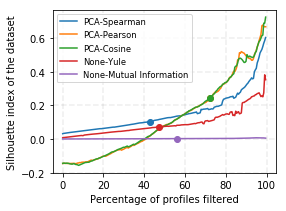

In [568]:
idx = np.argsort(qt.clust_index_filt_score['Silhouette'].values())[::-1]
keys = np.array(qt.clust_index_filt_score['Silhouette'].keys())[idx]
keys = keys[:5]

keys[-2] = 'None-Yule-None'
keys[-1] = 'None-Mutual Information-None'

plt.figure(figsize=(4,3))
N = len(qt.clust_index_filt_evol['Silhouette'][keys[0]])
X = np.arange(N)/float(N)*100

for i,key in enumerate(keys):
    p = plt.plot(X,qt.clust_index_filt_evol['Silhouette'][key],label=key.split('-None')[0])
    
    #Display Silhouette Zscore= 1.65
    X0 = qt.clust_index_filt_threshold['Silhouette'][key]/float(len(qt.labels))*100
    idx0 = np.argmin(np.abs(X-X0))
    plt.plot(X[idx0],qt.clust_index_filt_evol['Silhouette'][key][idx0],'o',c=p[-1].get_color())
    
#plt.ylim(ymin=0.2)
plt.legend(fontsize='small')
plt.xlabel('Percentage of profiles filtered')
plt.ylabel('Silhouette index of the dataset')
plt.grid(color='k',linestyle='--',linewidth=0.1)
plt.savefig('Silhouette_evolution_with_Filtering.png',dpi=300, bbox_inches='tight')
plt.show()

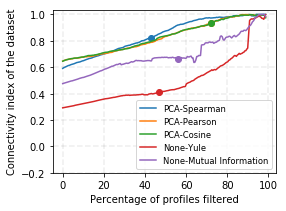

In [569]:
#idx = np.argsort(qt.clust_index_filt_score['Connectivity'].values())[::-1]
#keys = np.array(qt.clust_index_filt_score['Connectivity'].keys())[idx]

plt.figure(figsize=(4,3))
N = len(qt.clust_index_filt_evol['Connectivity'][key])
X = np.arange(N-2)/float(N)*100
for key in keys:
    p=plt.plot(X,qt.clust_index_filt_evol['Connectivity'][key][:-2],label=key.split('-None')[0])
    
    #Display Silhouette Zscore= 1.65
    X0 = qt.clust_index_filt_threshold['Connectivity'][key]/float(len(qt.labels))*100
    idx0 = np.argmin(np.abs(X-X0))
    plt.plot(X[idx0],qt.clust_index_filt_evol['Connectivity'][key][idx0],'o',c=p[-1].get_color())
    
plt.ylim(ymin=-0.2)
plt.legend(loc='lower right',fontsize='small')
plt.xlabel('Percentage of profiles filtered')
plt.ylabel('Connectivity index of the dataset')
plt.grid(color='k',linestyle='--',linewidth=0.1)
plt.savefig('Connectivity_evolution_with_Filtering.png',dpi=300, bbox_inches='tight')
plt.show()

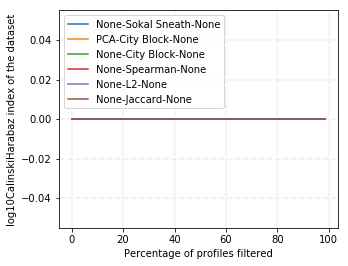

In [130]:
idx = np.argsort(qt.clust_index_filt_score['log10CalinskiHarabaz'].values())[::-1]
keys = np.array(qt.clust_index_filt_score['log10CalinskiHarabaz'].keys())[idx]

plt.figure(figsize=(5,4))
N = len(qt.clust_index_filt_evol['log10CalinskiHarabaz'][key])
X = np.arange(N-2)/float(N)*100
for key in keys[:5]:
    plt.plot(X,qt.clust_index_filt_evol['log10CalinskiHarabaz'][key][:-2],label=key)
    
plt.plot(X,qt.clust_index_filt_evol['log10CalinskiHarabaz']['None-Jaccard-None'][:-2],label='None-Jaccard-None')

#plt.ylim(ymin=0.5,ymax=1.3)
plt.legend(loc='upper left')
plt.xlabel('Percentage of profiles filtered')
plt.ylabel('log10CalinskiHarabaz index of the dataset')
plt.grid(color='k',linestyle='--',linewidth=0.1)
plt.savefig('log10CalinskiHarabaz_evolution_with_Filtering.png',dpi=300)
plt.show()

In [356]:
qt.WriteDistanceScore(Suffix='_scATACCont')

KeyError: 'None-Mutual Information-None'

## Saving and Loading

In [27]:
#Save Class
import cPickle as pickle
import dill  
with open('/home/invites/jmorlot/qt_Distmat_sc_ATAC.pkl', 'w') as f:
    pickle.dump(qt.Distmat,f)

In [13]:
#Load class
import cPickle as pickle
with open('/home/invites/jmorlot/qt_Distmat_sc_ATAC.pkl') as f:
    qt.Distmat = pickle.load(f)

In [ ]:
qt.compute_samples_quality(NR=100,Tz=1.65,return_Quality=False,Distance='Bray Curtis')
qt.display_samples_quality(Suffix='_scATACCont_BC_TSNE',DR='TSNE',names=namesCT)

perplexities:   0%|          | 0/8 [00:00<?, ?it/s]


# Dataset Total: 2755
# Dataset Kept: 649 (23.6 %)
# Dataset Removed: 2106 (76.4 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		171		3.19899178602		Cluster 0
1		1		1.82080330392		Cluster 1
2		70		3.29625422218		Cluster 2
3		68		2.02203755763		Cluster 3
4		72		10.6089378387		Cluster 4
5		38		4.93962316395		Cluster 5
10		147		4.32218221334		Cluster 10
11		82		10.4069258587		Cluster 11

Removed Datasets
Labels		Name
6		Cluster 6
7		Cluster 7
8		Cluster 8
9		Cluster 9



perplexities:  12%|█▎        | 1/8 [04:11<29:22, 251.80s/it]

In [19]:
qt.compute_samples_quality(matrix=matrix,labels=labels,NR=100,Tz=1.65,return_Quality=False)
qt.display_samples_quality(Suffix='_scATACCont_TSNE',DR='TSNE',names=namesCT)

Using Optimal (PCA,Distance,Kernel) = ('PCA', 'Chebyshev', 'None')


perplexities:   0%|          | 0/8 [00:00<?, ?it/s]


# Dataset Total: 2755
# Dataset Kept: 276 (10.0 %)
# Dataset Removed: 2479 (90.0 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
1		16		2.13527792689		Cluster 1
2		65		3.27033500658		Cluster 2
3		1		2.31010331998		Cluster 3
4		9		2.35936302748		Cluster 4
5		77		5.52100808132		Cluster 5
9		39		3.8193562889		Cluster 9
10		42		3.01132516697		Cluster 10
11		27		4.11291347541		Cluster 11

Removed Datasets
Labels		Name
0		Cluster 0
6		Cluster 6
7		Cluster 7
8		Cluster 8


KeyboardInterrupt: 

In [360]:
IdxGoodSamples = qt.compute_samples_quality(NR=100,Tz=1.65,Distance='Euclidean',Kernel='None',PCA='None')
qt.display_samples_quality(Suffix='_scATACCont_N-Euclidean-N_TSNE',DR='TSNE',names=namesCT)



learning rates:   0%|          | 0/3 [00:00<?, ?it/s]


perplexities:   0%|          | 0/8 [00:00<?, ?it/s]


# Dataset Total: 2755
# Dataset Kept: 110 (4.0 %)
# Dataset Removed: 2645 (96.0 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
5		110		5.04473132527		Cluster 5

Removed Datasets
Labels		Name
0		Cluster 0
1		Cluster 1
2		Cluster 2
3		Cluster 3
4		Cluster 4
6		Cluster 6
7		Cluster 7
8		Cluster 8
9		Cluster 9
10		Cluster 10
11		Cluster 11



Exception in thread Thread-28:
Traceback (most recent call last):
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




perplexities:  12%|█▎        | 1/8 [03:59<27:57, 239.67s/it]


perplexities:  25%|██▌       | 2/8 [07:50<23:32, 235.38s/it]


perplexities:  38%|███▊      | 3/8 [14:29<24:09, 289.92s/it]


perplexities:  50%|█████     | 4/8 [26:45<26:45, 401.27s/it]


perplexities:  62%|██████▎   | 5/8 [48:23<29:02, 580.79s/it]


perplexities:  75%|███████▌  | 6/8 [1:03:40<21:13, 636.81s/it]


perplexities:  88%|████████▊ | 7/8 [1:18:28<11:12, 672.71s/it]


perplexities: 100%|██████████| 8/8 [1:58:51<00:

Optimal (learning rate,perplexity) = (10,100)


perplexities:   0%|          | 0/8 [00:00<?, ?it/s]



ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
IdxGoodSamples = qt.compute_samples_quality(NR=100,Tz=1.65,Distance='Pearson',Kernel='None',PCA='PCA')
qt.display_samples_quality(Suffix='_scATACCont_PCA-Pearson-N_TSNE',DR='TSNE',names=namesCT)

In [ ]:
IdxGoodSamples = qt.compute_samples_quality(NR=100,Tz=1.65,Distance='Mutual Information',Kernel='None',PCA='None')
qt.display_samples_quality(Suffix='_scATACCont_N-MutualInformation-N_TSNE',DR='TSNE',names=namesCT)

Remove sum outliers


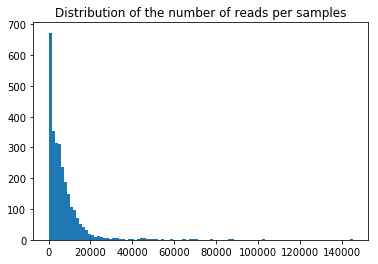

Lower threshold = 128
Upper threshold = 45590
Number of removed samples = 257 / 2755
Computing Distance matrix


KeyboardInterrupt: 

In [20]:
#Stand-alone Quality Tester
qt = QT.QualityTester()
IdxGoodSamples = qt.compute_samples_quality(matrix=matrix,labels=labels,NR=100,Tz=1.65,PCA='PCA',Distance='Spearman',Kernel='None')

In [111]:
IdxGoodSamples = qt.compute_samples_quality(NR=100,Tz=1.65)

Using Optimal (PCA,Distance,Kernel) = ('PCA', 'Spearman', 'None')

# Dataset Total: 2755
# Dataset Kept: 1171 (42.5 %)
# Dataset Removed: 1584 (57.5 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		372		4.22220369227		Cluster 0
1		5		2.21267566929		Cluster 1
2		171		4.03915932293		Cluster 2
3		186		2.48496683934		Cluster 3
4		72		7.83682282434		Cluster 4
5		109		8.78234805814		Cluster 5
9		40		2.67992091943		Cluster 9
10		134		4.53954371406		Cluster 10
11		82		12.3994843967		Cluster 11

Removed Datasets
Labels		Name
6		Cluster 6
7		Cluster 7
8		Cluster 8


learning rates: 100%|██████████| 3/3 [2:25:07<00:00, 2902.55s/it]


Optimal (learning rate,perplexity) = (100,1000)


perplexities:  88%|████████▊ | 7/8 [16:23<02:20, 140.55s/it]/users/invites/jmorlot/anaconda2/lib/python2.7/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)

learning rates: 100%|██████████| 3/3 [45:40<00:00, 913.42s/it]


Optimal (learning rate,perplexity) = (1000,30)


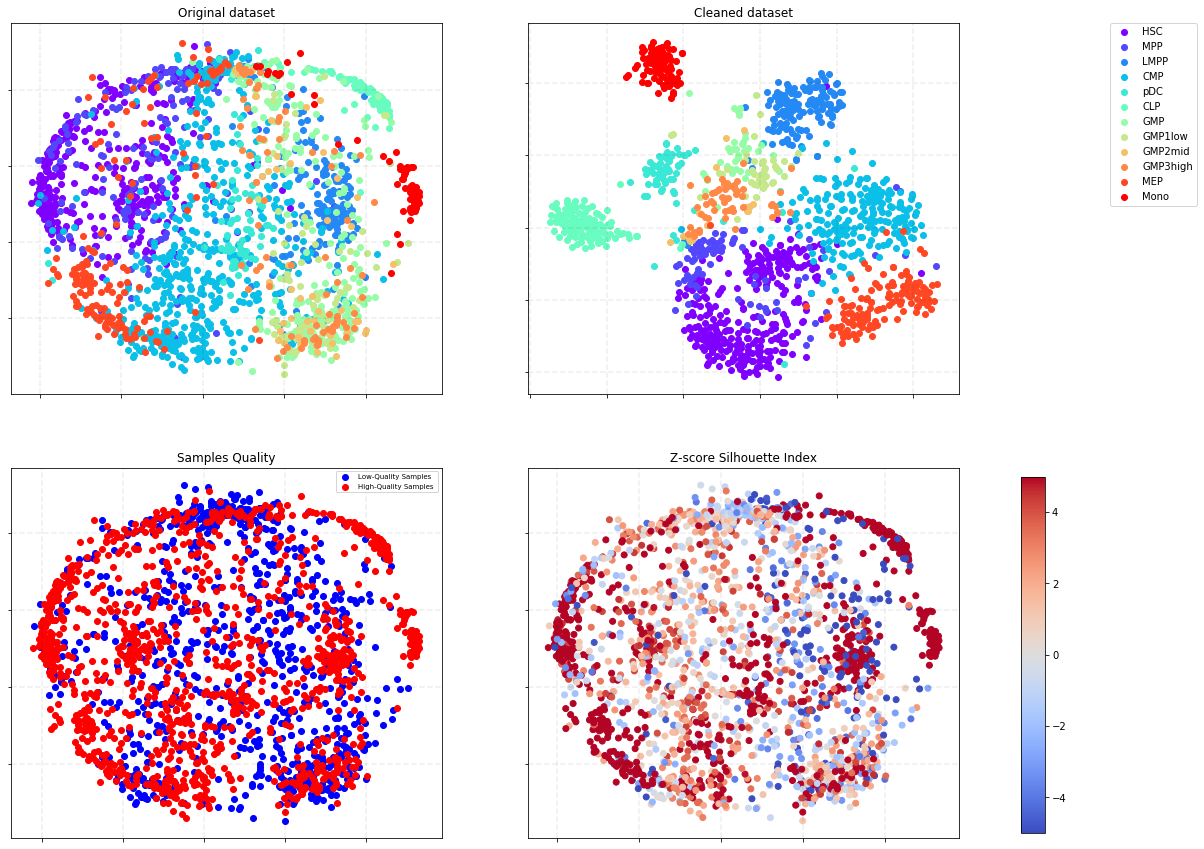

In [13]:
qt.display_samples_quality(Suffix='_scATACCont_TSNE',DR='TSNE',names=namesCT)

/users/invites/jmorlot/anaconda2/lib/python2.7/site-packages/sklearn/manifold/mds.py:407: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


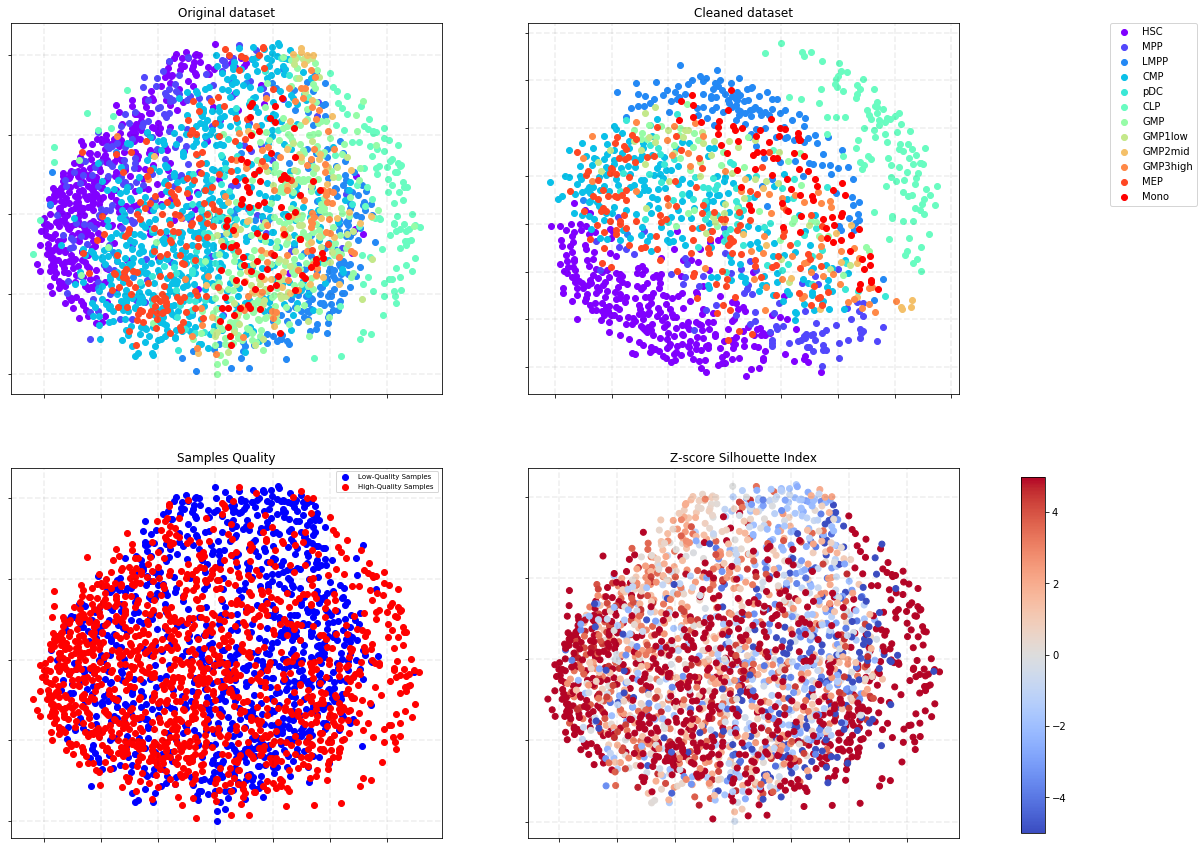

In [14]:
qt.display_samples_quality(Suffix='_scATACCont_MDS',DR='MDS',names=namesCT)

In [17]:
IdxGoodSamples = qt.compute_samples_quality(matrix=matrix,labels=labels,NR=100,Tz=1.65,Distance='Spearman',Kernel='None',PCA='None')

Computing Distance matrix

# Dataset Total: 2755
# Dataset Kept: 683 (24.8 %)
# Dataset Removed: 2072 (75.2 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		213		2.47260629967		Cluster 0
2		9		1.96350245668		Cluster 2
3		157		2.03010695953		Cluster 3
4		72		11.9838200338		Cluster 4
10		150		4.37256539053		Cluster 10
11		82		11.4313240366		Cluster 11

Removed Datasets
Labels		Name
1		Cluster 1
5		Cluster 5
6		Cluster 6
7		Cluster 7
8		Cluster 8
9		Cluster 9


In [119]:
sils = dict()
qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='PCA',Distance='Spearman',Kernel='None',return_Quality=False)
sils['PCA-SP-None'] = qt.SilZ 

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Yule',Kernel='None',return_Quality=False)
sils['None-Y-None'] = qt.SilZ 

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Euclidean',Kernel='None',return_Quality=False)
sils['None-E-None'] = qt.SilZ 

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Pearson',Kernel='None',return_Quality=False)
sils['None-P-None'] = qt.SilZ 



Computing Distance matrix


KeyboardInterrupt: 

In [128]:

silmat = np.zeros((len(sils),len(sils)))
for ix,Sx in enumerate(sils.keys()):
    for iy,Sy in enumerate(sils.keys()):
        silmat[ix,iy] = (np.sum(np.logical_and(sils[Sx]>1.65,sils[Sy]<=1.65))+np.sum(np.logical_and(sils[Sy]>1.65,sils[Sx]<=1.65)))/float(matrix.shape[0])*100
        print Sx,Sy,silmat[ix,iy]
        
print sils.keys()
print silmat

None-E-None None-E-None 0.0
None-E-None None-Y-None 38.8384754991
None-E-None PCA-SP-None 41.7059891107
None-E-None None-P-None 29.8366606171
None-Y-None None-E-None 38.8384754991
None-Y-None None-Y-None 0.0
None-Y-None PCA-SP-None 18.8384754991
None-Y-None None-P-None 23.1578947368
PCA-SP-None None-E-None 41.7059891107
PCA-SP-None None-Y-None 18.8384754991
PCA-SP-None PCA-SP-None 0.0
PCA-SP-None None-P-None 30.5263157895
None-P-None None-E-None 29.8366606171
None-P-None None-Y-None 23.1578947368
None-P-None PCA-SP-None 30.5263157895
None-P-None None-P-None 0.0
['None-E-None', 'None-Y-None', 'PCA-SP-None', 'None-P-None']
[[  0.          38.8384755   41.70598911  29.83666062]
 [ 38.8384755    0.          18.8384755   23.15789474]
 [ 41.70598911  18.8384755    0.          30.52631579]
 [ 29.83666062  23.15789474  30.52631579   0.        ]]


In [42]:
sils[keyy].shape

(2498,)

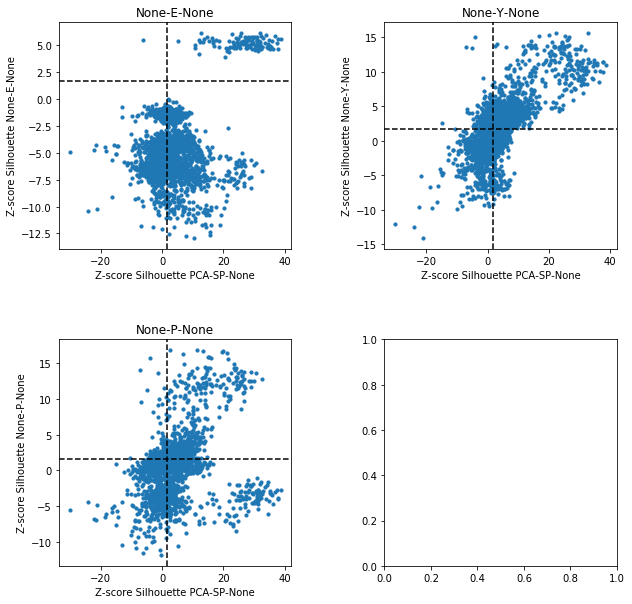

In [129]:
from matplotlib.pyplot import cm 

keyx = 'PCA-SP-None'
colors=cm.rainbow(np.linspace(0,1,len(sils.keys())))
f,ax = plt.subplots(2,2,figsize=(10,10))
for i,(keyy,ax) in enumerate(zip(*[[key for key in sils.keys() if key!=keyx],ax.flatten()])):
        #idx = np.where(np.logical_and(sils[keyx]>1.65,sils[keyy]<=1.65))
        ax.scatter(sils[keyx],sils[keyy],s=10)
        #ax.scatter(sils[keyx][idx],sils[keyy][idx],color='r',s=10)
        ax.set_title(keyy)
        ax.axhline(y=1.65,color='k',linestyle='--')
        ax.axvline(x=1.65,color='k',linestyle='--')
        ax.set_xlabel('Z-score Silhouette '+ keyx)
        ax.set_ylabel('Z-score Silhouette '+ keyy)
        
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig('Comparison_Zscore_ATAC.png',dpi=300)
plt.show()

### Connectivity Quality

In [123]:
conns = dict()
sils = dict()

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='PCA',Distance='Spearman',Kernel='None',return_Quality=False)
conns['PCA-SP-None'] = qt.ConnZ 
sils['PCA-SP-None'] = qt.SilZ 

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Yule',Kernel='None',return_Quality=False)
conns['None-Y-None'] = qt.ConnZ 
sils['None-Y-None'] = qt.SilZ 

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Euclidean',Kernel='None',return_Quality=False)
conns['None-E-None'] = qt.ConnZ 
sils['None-E-None'] = qt.SilZ 

qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Pearson',Kernel='None',return_Quality=False)
conns['None-P-None'] = qt.ConnZ 
sils['None-P-None'] = qt.SilZ 


conmat = np.zeros((len(conns),len(conns)))
for ix,Sx in enumerate(conns.keys()):
    for iy,Sy in enumerate(conns.keys()):
        conmat[ix,iy] = (np.sum(np.logical_and(conns[Sx]>1.65,conns[Sy]<=1.65))+np.sum(np.logical_and(conns[Sy]>1.65,conns[Sx]<=1.65)))/float(matrix.shape[0])*100
        print Sx,Sy,conmat[ix,iy]
        
print conns.keys()
print conmat

Computing Distance matrix




  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-15:
Traceback (most recent call last):
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 10%|█         | 1/10 [05:47<52:05, 347.27s/it]

 20%|██        | 2/10 [11:34<46:18, 347.28s/it]

 30%|███       | 3/10 [17:22<40:32, 347.56s/it]

 40%|████      | 4/10 [23:10<34:45, 347.65s/it]

 50%|█████     | 5/10 [28:58<28:58, 347.80s/it]

 60%|██████    | 6/10 [34:46<23:11, 347.82s/it]

 70%|███████   | 7/10 [40:34<17:23, 347.84s/it]

 80%|████████  | 8/10 [46:22<11:35, 347.86s/it]

 90%|█████████ | 9/10 [52:11<05:47, 347.94s/it]

100%|███████


# Dataset Total: 2755
# Dataset Kept: 1257 (45.6 %)
# Dataset Removed: 1498 (54.4 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		295		5.37169495748		HSC
1		80		3.36004812894		MPP
2		133		8.8180762144		LMPP
3		211		4.04786341362		CMP
4		63		10.1735443613		pDC
5		109		26.5968323498		CLP
6		40		2.76445987523		GMP
7		42		4.04981069602		GMP1low
8		16		3.57578943049		GMP2mid
9		56		4.92215494729		GMP3high
10		133		8.55410394245		MEP
11		79		20.5554252207		Mono
Computing Distance matrix

# Dataset Total: 2755
# Dataset Kept: 1178 (42.8 %)
# Dataset Removed: 1577 (57.2 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		371		4.15332793029		HSC
1		5		2.0380243496		MPP
2		171		3.87447990236		LMPP
3		191		2.51741054694		CMP
4		72		7.73294669261		pDC
5		109		8.48771892209		CLP
9		40		2.59937742206		GMP3high
10		137		4.51784996997		MEP
11		82		12.9789867657		Mono

Removed Datasets
Labels		Name
6		GMP
7		GMP1low
8		GMP2mid
Computing Distance matrix

# Dataset Total:

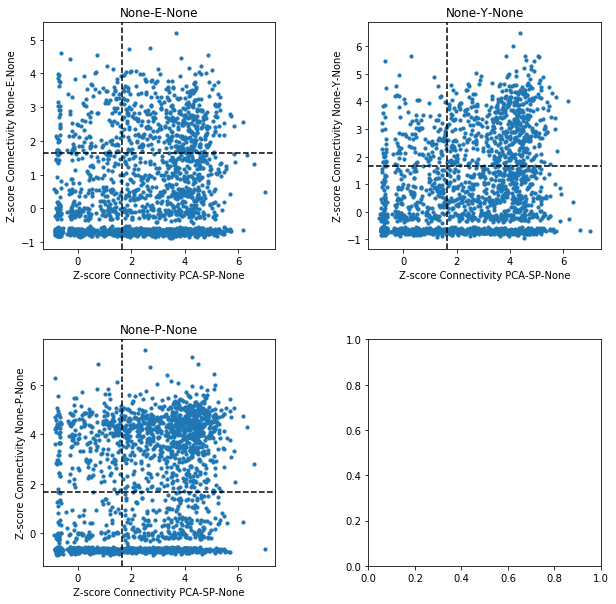

In [130]:
from matplotlib.pyplot import cm 

keyx = 'PCA-SP-None'
colors=cm.rainbow(np.linspace(0,1,len(conns.keys())))
f,ax = plt.subplots(2,2,figsize=(10,10))
for i,(keyy,ax) in enumerate(zip(*[[key for key in conns.keys() if key!=keyx],ax.flatten()])):
        #idx = np.where(np.logical_and(sils[keyx]>1.65,sils[keyy]<=1.65))
        ax.scatter(conns[keyx],conns[keyy],s=10)
        #ax.scatter(sils[keyx][idx],sils[keyy][idx],color='r',s=10)
        ax.set_title(keyy)
        ax.axhline(y=1.65,color='k',linestyle='--')
        ax.axvline(x=1.65,color='k',linestyle='--')
        ax.set_xlabel('Z-score Connectivity '+ keyx)
        ax.set_ylabel('Z-score Connectivity '+ keyy)
        
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig('Comparison_Zscore_Colnnectivity_ATAC.png',dpi=300)
plt.show()

In [135]:
import QualityMesures as QM
IdxGoodSamples,SilZ = QM.ZscoreSilhouetteQuality(OptDistMat=qt.OptimalDistance,labels=qt.labels,Tz=1.65,NR=100)

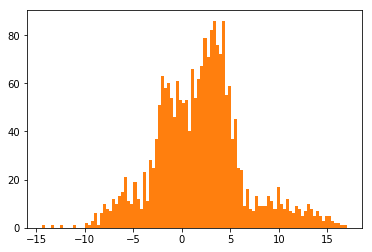

In [138]:
plt.hist(SilZ,100)
plt.show()

In [151]:
#qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Yule',Kernel='None',return_Quality=False)
qt.display_samples_quality(Suffix='_scATACCont_Yule_TSNE',DR='TSNE',names=namesCT)

perplexities:  62%|██████▎   | 5/8 [07:47<04:40, 93.56s/it]


KeyboardInterrupt: 

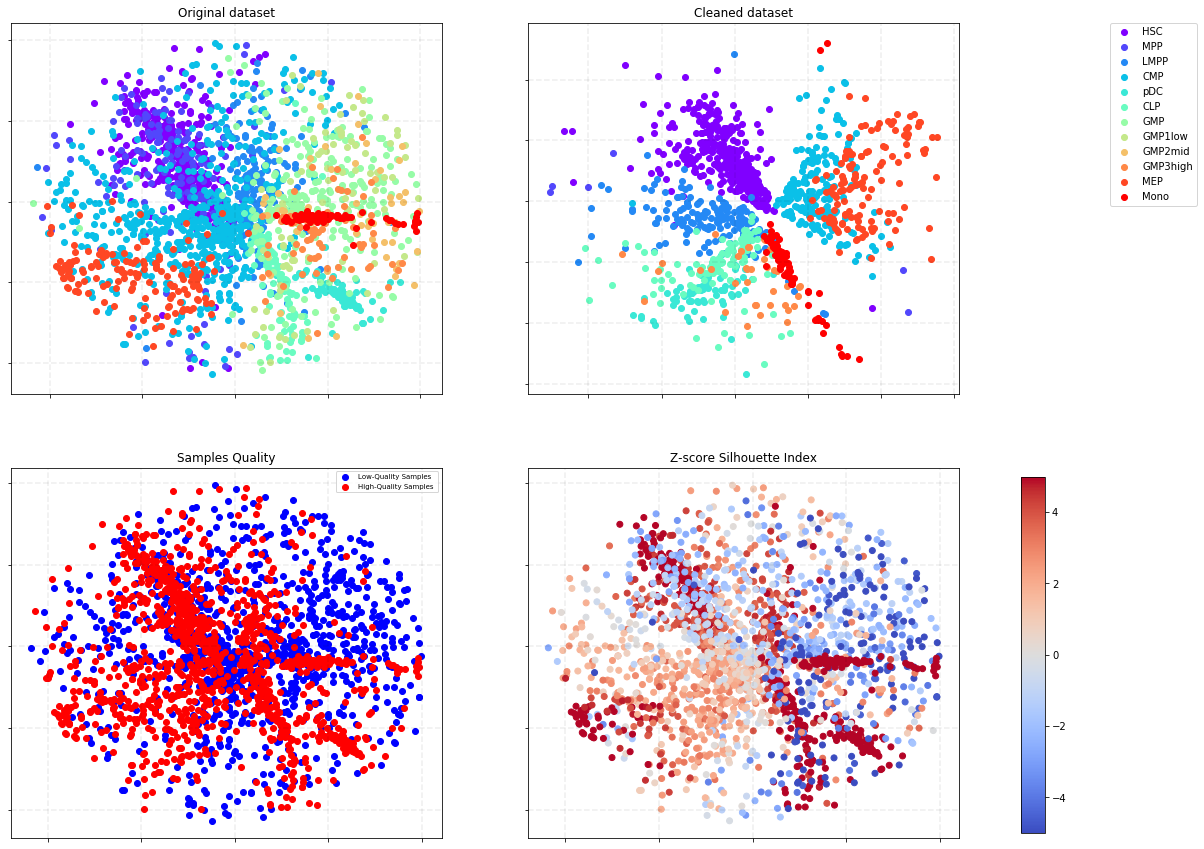

In [132]:
qt.display_samples_quality(Suffix='_scATACCont_Yule_TSNE',DR='TSNE',names=namesCT,perplexity=1000,learning_rate=100)

## Evolution clustering index by setting a threshold

In [22]:
qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Yule',Kernel='None',return_Quality=False)

Computing Distance matrix

# Dataset Total: 2755
# Dataset Kept: 1184 (43.0 %)
# Dataset Removed: 1571 (57.0 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		382		3.71748438507		HSC
1		13		2.16495896743		MPP
2		180		3.79529180746		LMPP
3		151		2.31054812457		CMP
4		55		4.178844743		pDC
5		114		7.69908467881		CLP
9		38		2.66341254324		GMP3high
10		159		3.92503505748		MEP
11		92		11.5540020816		Mono

Removed Datasets
Labels		Name
6		GMP
7		GMP1low
8		GMP2mid


In [25]:
X=[]
Y=[]
M=[]
idxS = np.argsort(qt.SilZ)
for i in tqdm(range(len(idxS)//10)):
    try:
        idx = idxS[i*10:]
        distmatC = qt.OptimalDistance[np.ix_(idx,idx)]
        labelsC = qt.labels[idx]
        labels_tmp = labelsC.copy()
        for k,l in enumerate(np.unique(qt.labels)):
            labels_tmp[labelsC==l] = k
        labelsC = labels_tmp

        X.append(QT.silhouette_score(distmatC,labelsC))
        Y.append(QT.Connectivity(distmatC,labelsC))
        M.append(qt.SilZ[idxS[i*10]])
    except:
        break

100%|██████████| 249/249 [00:53<00:00,  4.63it/s]


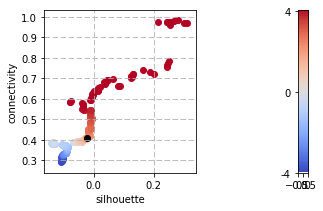

In [147]:
from matplotlib.pyplot import cm

T=1.65

def fT(k):
    if k>4:
        return 4
    elif k<-4:
        return -4
    else:
        return k
        

f,ax = plt.subplots(1,2,figsize=(6,3))
color=cm.coolwarm(np.linspace(0,1,101))
Mmin = -4
Mmax = 8
for i in range(len(X)-4):
    ax[0].scatter(X[i],Y[i],c=color[int((float(fT(M[i])-Mmin)/Mmax)*100)])
    if fT(M[i])>T and fT(M[i-1])<T:
        i0=i
        
#Set in black the position of the threshold
ax[0].scatter(X[i0],Y[i0],c='k')

ax[0].set_xlabel('silhouette')
ax[0].set_ylabel('connectivity')
ax[0].grid('k',linestyle='--')

ax[1].imshow(np.arange(100)[::-1,None],aspect=0.15,cmap='coolwarm')
ax[1].set_yticks(np.arange(0,101,50))
ax[1].set_yticklabels([4,0,-4])

plt.savefig('Clustering_index_evolution_with_SilZscore_Yule.png',dpi=300)
plt.show()

In [63]:
reload(QT)

<module 'QualityTester' from '../QualityTester.py'>

In [73]:
SilTruncEvol,SilScore = qt.qualitysilhouettescore()

PCA-Cosine-None
Computing Distance matrix

# Dataset Total: 2755
# Dataset Kept: 884 (32.1 %)
# Dataset Removed: 1871 (67.9 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		196		3.77022596927		Cluster 0
1		42		2.02631738156		Cluster 1
2		76		1.79650103118		Cluster 2
3		151		0.993525092035		Cluster 3
4		54		13.8706704102		Cluster 4
5		101		7.63810475069		Cluster 5
6		14		1.02074851277		Cluster 6
7		50		3.33078673347		Cluster 7
8		5		0.97364645204		Cluster 8
9		20		2.85070619583		Cluster 9
10		113		8.47382861764		Cluster 10
11		62		15.4142662941		Cluster 11
--> score = 0.491758521108
PCA-L2-None
Computing Distance matrix

# Dataset Total: 2755
# Dataset Kept: 571 (20.7 %)
# Dataset Removed: 2184 (79.3 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		129		1.2754522277		Cluster 0
1		116		1.5324932854		Cluster 1
2		57		1.59683263557		Cluster 2
3		19		0.333161824874		Cluster 3
5		110		3.64463512872		Cluster 5
6		24		0.461855210521		Cluster 6
9		64		3.3345776

KeyboardInterrupt: 

In [69]:
SilScore

{}

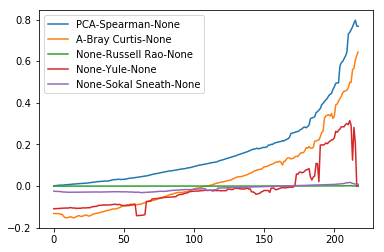

In [80]:
plt.plot(SilTruncEvol['PCA-Spearman-None'],label='PCA-Spearman-None')
plt.plot(SilTruncEvol['PCA-Bray Curtis-None'],label='A-Bray Curtis-None')
plt.plot(SilTruncEvol['None-Russell Rao-None'],label='None-Russell Rao-None')
plt.plot(SilTruncEvol['None-Yule-None'],label='None-Yule-None')
plt.plot(SilTruncEvol['None-Sokal Sneath-None'],label='None-Sokal Sneath-None')
plt.legend()
plt.show()

In [85]:
qt.compute_samples_quality(Tz=1.65,NR=100,names=namesCT,PCA='None',Distance='Yule',Kernel='None',return_Quality=False) 

Computing Distance matrix

# Dataset Total: 2755
# Dataset Kept: 1171 (42.5 %)
# Dataset Removed: 1584 (57.5 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		372		4.27758451093		HSC
1		4		2.21855212503		MPP
2		170		3.91975131471		LMPP
3		190		2.44591737293		CMP
4		72		7.62312148387		pDC
5		109		8.33616918676		CLP
9		40		2.59687405645		GMP3high
10		132		4.53466191628		MEP
11		82		12.8685125243		Mono

Removed Datasets
Labels		Name
6		GMP
7		GMP1low
8		GMP2mid


In [87]:
idxS = np.argsort(qt.SilZ)
NS = len(idxS)//10 - 1
Sil = np.ones(NS)*(-1)
Conn = np.zeros(NS)
Zscore = np.zeros(NS)

for i in range(NS):
    idx = idxS[i*10:]
    distmatC = qt.OptimalDistance[np.ix_(idx,idx)]
    labelsC = qt.labels[idx]

    labels_tmp = labelsC.copy()
    for k,l in enumerate(np.unique(labelsC)):
        labels_tmp[labelsC==l] = k
    labelsC = labels_tmp

    Sil[i] = QT.silhouette_score(distmatC,labelsC)
    Conn[i] = QT.Connectivity(distmatC,labelsC)
    Zscore[i] = qt.SilZ[idxS[i*10]]

In [91]:
qt.Res['Silhouette']

{'None-Bray Curtis-None': 0.0063036213416354601,
 'None-Cosine-None': 0.010396442659523036,
 'None-Dice-None': 0.0057675144480423303,
 'None-Jaccard-None': 0.0034797269059528781,
 'None-Pearson-None': 0.0079156293449297675,
 'None-Russell Rao-None': 0.0003443645803053662,
 'None-Sokal Sneath-None': 0.0016048324290271676,
 'None-Spearman-None': 0.0082309108794812926,
 'None-Yule-None': 0.070626622909720854,
 'PCA-Bray Curtis-None': 0.10010922551857743,
 'PCA-Canberra-None': 0.031886958589321987,
 'PCA-Chebyshev-None': 0.39289873246088808,
 'PCA-City Block-None': 0.053863118846614669,
 'PCA-Cosine-None': 0.2545086252996886,
 'PCA-Euclidean-None': 0.11289691848213949,
 'PCA-L2-None': 0.099397183171195932,
 'PCA-Pearson-None': 0.24911636776704785,
 'PCA-Spearman-None': 0.10395606062707885,
 'PCA-Squared Euclidean-None': 0.11197098007663621}

In [90]:
print QT.silhouette_score(qt.OptimalDistance,qt.labels)
print QT.Connectivity(qt.OptimalDistance,qt.labels)

-0.109044564204
0.292329456772


In [88]:
print Sil

[-0.10904456 -0.1086995  -0.10839861 -0.10781861 -0.10765733 -0.10701154
 -0.10688434 -0.10609731 -0.10613615 -0.10670805 -0.1050257  -0.10522058
 -0.10537383 -0.10474389 -0.10427437 -0.10891715 -0.10933891 -0.10740098
 -0.10702767 -0.10696982 -0.10764816 -0.10726807 -0.1056771  -0.1055861
 -0.10493736 -0.10460573 -0.10222134 -0.10085891 -0.10128519 -0.10097506
 -0.09819778 -0.09333387 -0.09365213 -0.09313327 -0.09328226 -0.09307586
 -0.093353   -0.09277802 -0.09139741 -0.09040068 -0.08991855 -0.08827889
 -0.08833579 -0.08814671 -0.0873637  -0.08578402 -0.08549138 -0.08524747
 -0.08516302 -0.08642487 -0.0861276  -0.08543116 -0.08467637 -0.08439922
 -0.08447743 -0.08389428 -0.0823873  -0.09353787 -0.11072964 -0.10238208
 -0.12213291 -0.1415226  -0.14081626 -0.07866905 -0.07810162 -0.07709197
 -0.07476129 -0.07344733 -0.06926304 -0.06834845 -0.06685143 -0.06648396
 -0.06482759 -0.06398701 -0.06380679 -0.05835118 -0.05768449 -0.05707222
 -0.05527663 -0.05481733 -0.05406118 -0.05421553 -0.

In [84]:
SilTruncEvol['None-Yule-None']

array([-0.10904456, -0.10871575, -0.10815353, -0.10819397, -0.10754215,
       -0.10727737, -0.10644195, -0.10618962, -0.10570505, -0.10566276,
       -0.10612439, -0.10450735, -0.1036634 , -0.10484539, -0.10610405,
       -0.10513092, -0.10808589, -0.10657045, -0.10691528, -0.10697534,
       -0.10532279, -0.105351  , -0.10497102, -0.10503937, -0.10441593,
       -0.10440592, -0.10396814, -0.10003986, -0.09971237, -0.09758961,
       -0.09799424, -0.09673943, -0.09273538, -0.09262257, -0.0923863 ,
       -0.09096721, -0.09109929, -0.09111789, -0.09071981, -0.09082931,
       -0.09093976, -0.08990953, -0.08911338, -0.08778164, -0.08751873,
       -0.08932237, -0.08875903, -0.08823545, -0.09240328, -0.0931531 ,
       -0.09420899, -0.09490315, -0.0944535 , -0.09298792, -0.09387467,
       -0.09120843, -0.0919336 , -0.08686783, -0.08749326, -0.14224741,
       -0.14211647, -0.14136259, -0.14038943, -0.14018012, -0.13948409,
       -0.13713479, -0.07436771, -0.07341457, -0.07265382, -0.07

In [82]:
SilTruncEvol['None-Russell Rao-None']

array([ -3.68605216e-04,  -3.70343019e-04,  -3.70299882e-04,
        -3.73123960e-04,  -3.74807131e-04,  -3.74815456e-04,
        -3.78225843e-04,  -3.78173729e-04,  -3.77306791e-04,
        -3.77251324e-04,  -3.76902060e-04,  -3.88591651e-04,
        -3.95363254e-04,  -4.01365812e-04,  -3.98846750e-04,
        -3.89285001e-04,  -4.03780544e-04,  -4.03770676e-04,
        -3.77782356e-04,  -3.77712939e-04,  -3.78869386e-04,
        -3.75058622e-04,  -3.75487574e-04,  -3.70295974e-04,
        -3.84738369e-04,  -3.87293418e-04,  -3.91584751e-04,
        -4.10231792e-04,  -4.07128342e-04,  -4.02364701e-04,
        -4.00409558e-04,  -3.28895382e-04,  -3.33356816e-04,
        -3.32313775e-04,  -3.31749279e-04,  -3.30997214e-04,
        -3.29615253e-04,  -3.38793898e-04,  -3.39851448e-04,
        -3.40008519e-04,  -3.38976120e-04,  -3.43779237e-04,
        -3.42929143e-04,  -3.42964599e-04,  -3.43028562e-04,
        -3.40927306e-04,  -3.47656349e-04,  -3.47130228e-04,
        -3.46220601e-04,

In [79]:
idx = np.argsort(SilScore.values())[::-1]
keys = np.array(SilScore.keys())[idx]

for key in keys:
    print key,SilScore[key]

PCA-Spearman-None 0.5842772996
PCA-Bray Curtis-None 0.521746238269
None-Russell Rao-None 0.499944212318
None-Yule-None 0.49443012048
None-Sokal Sneath-None 0.49355810282
PCA-Cosine-None 0.491852980853
PCA-Pearson-None 0.491326742035
PCA-Canberra-None 0.483842719513
None-Jaccard-None 0.480457957213
None-Spearman-None 0.474480753085
None-Pearson-None 0.47401135012
PCA-Chebyshev-None 0.469785099298
None-Cosine-None 0.468937005737
None-Dice-None 0.461122895482
None-Bray Curtis-None 0.460957204436
PCA-Euclidean-None 0.418610504432
PCA-L2-None 0.418538173488
PCA-City Block-None 0.353537071768
PCA-Squared Euclidean-None 0.338989443043


# Evolution of the distance measure on clustering indexes 

In [15]:
IdxGoodSamplesO,SilZO,OptimalDistanceO = qt.compute_samples_quality(NR=100,Tz=1.65,return_Quality=True)

Error: Need to enter a PCA-Distance-Kernel or launch all measures with compute_distances()


ValueError: 

In [33]:
import QualityMesures as QM
reload(QM)
_,CZ = QM.ZscoreConnectivityQuality(OptDistMat=qt.OptimalDistance,labels=qt.labels,NR=100,Tz=1.65)

In [142]:
reload(QT)

<module 'QualityTester' from '../QualityTester.pyc'>

In [63]:
qt.SilZ[idxS]

array([-30.20318243, -24.02159   , -22.34891912, ...,  37.68716795,
        37.76766758,  38.72301108])

In [69]:
X=[]
Y=[]
M=[]
idxS = np.argsort(qt.SilZ)
for i in tqdm(range(len(idxS)//10)):
    idx = idxS[i*10:]
    distmatC = qt.OptimalDistance[np.ix_(idx,idx)]
    labelsC = qt.labels[idx]
    labels_tmp = labelsC.copy()
    for k,l in enumerate(np.unique(qt.labels)):
        labels_tmp[labelsC==l] = k
    labelsC = labels_tmp
    
    X.append(QT.silhouette_score(distmatC,labelsC))
    Y.append(QT.Connectivity(distmatC,labelsC))
    M.append(qt.SilZ[idxS[i*10]])

 89%|████████▉ | 195/219 [00:41<00:05,  4.69it/s]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

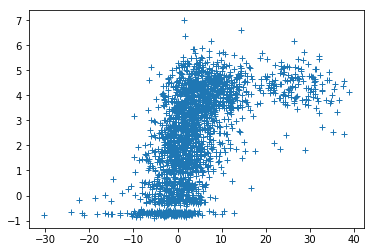

In [34]:
plt.plot(qt.SilZ,CZ,'+')
plt.show()

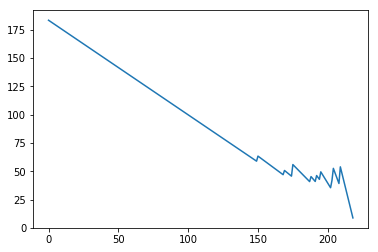

In [80]:
plt.plot(range(len(idxS)//10),M)
plt.show()

In [144]:
fT(M[i])

0.090297588757909206

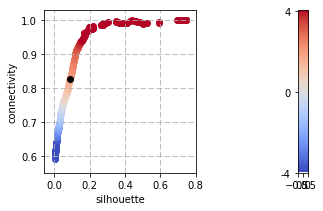

In [157]:
from matplotlib.pyplot import cm

T=1.65

def fT(k):
    if k>4:
        return 4
    elif k<-4:
        return -4
    else:
        return k
        

f,ax = plt.subplots(1,2,figsize=(6,3))
color=cm.coolwarm(np.linspace(0,1,101))
Mmin = -4
Mmax = 8
for i in range(len(X)-4):
    ax[0].scatter(X[i],Y[i],c=color[int((float(fT(M[i])-Mmin)/Mmax)*100)])
    if fT(M[i])>T and fT(M[i-1])<T:
        i0=i
        
#Set in black the position of the threshold
ax[0].scatter(X[i0],Y[i0],c='k')

ax[0].set_xlabel('silhouette')
ax[0].set_ylabel('connectivity')
ax[0].grid('k',linestyle='--')

ax[1].imshow(np.arange(100)[::-1,None],aspect=0.15,cmap='coolwarm')
ax[1].set_yticks(np.arange(0,101,50))
ax[1].set_yticklabels([4,0,-4])

plt.savefig('Clustering_index_evolution_with_SilZscore.png',dpi=300)
plt.show()

1248


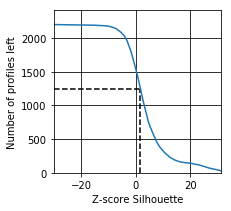

In [140]:
y0 = len(idxS)-np.arange(0,len(idxS),10)[i0]
print y0
plt.figure(figsize=(3,3))
plt.plot(M,len(idxS)-np.arange(0,len(idxS)-20,10))
plt.vlines(x=1.65,ymin=0,ymax=y0,linestyles='--')
plt.hlines(y=y0,xmin=min(M),xmax=1.65,linestyles='--')
plt.xlim([min(M),max(M)])
plt.ylim([0,len(idxS)*1.1])
plt.grid(color='k',linestyle='-')
plt.xlabel('Z-score Silhouette')
plt.ylabel('Number of profiles left')
plt.savefig('Number_of_profiles_with_SilZscore.png',dpi=300)
plt.show()

# Visualization

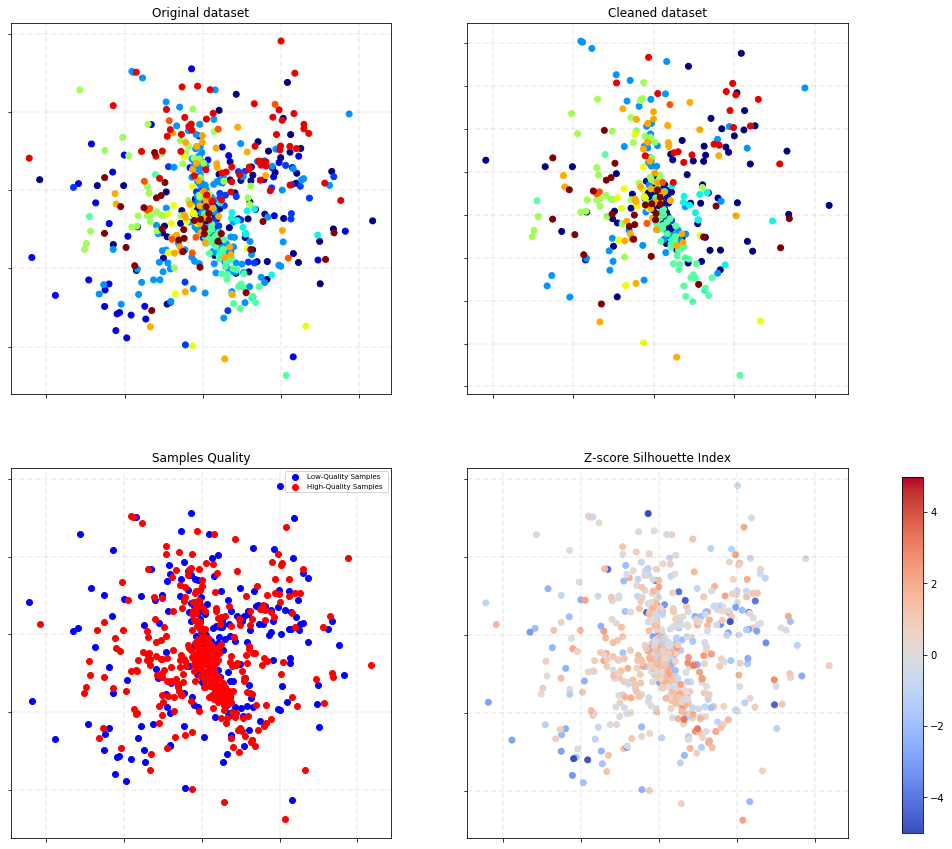

In [104]:
#Reduction Dimension
from sklearn import manifold
from matplotlib.pyplot import cm 

model_tsne = manifold.TSNE(n_components=2, random_state=3,perplexity=500, 
     early_exaggeration=4.0, learning_rate=10, 
     n_iter=100000, metric='precomputed')
# model_tsne = manifold.TSNE(n_components=2, metric='precomputed')
#model_MDS = manifold.MDS(n_components=2, dissimilarity='precomputed')

XY = model_tsne.fit_transform(qt.OptDistMat)

labelsGood = np.zeros(len(labels))
labelsGood[qt.IdxGoodSamples] = 1

f,ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].scatter(XY[:,0],XY[:,1],c=qt.labels,cmap='jet')
ax[0,0].set_title('Original dataset')
ax[0,0].grid(color='k',linestyle='--',linewidth=0.1)
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])

ax[0,1].scatter(XY[qt.IdxGoodSamples,0],XY[qt.IdxGoodSamples,1],c=labels[qt.IdxGoodSamples],cmap='jet')
ax[0,1].set_title('Cleaned dataset')
ax[0,1].grid(color='k',linestyle='--',linewidth=0.1)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])

color=cm.bwr(np.linspace(0,1,2))
for i in range(2):
    ax[1,0].scatter(XY[labelsGood==i,0],XY[labelsGood==i,1],c=color[i])

ax[1,0].grid(color='k',linestyle='--',linewidth=0.1)
ax[1,0].legend(['Low-Quality Samples','High-Quality Samples '],loc=0,fontsize='x-small')
ax[1,0].set_title('Samples Quality')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])

cax = ax[1,1].scatter(XY[:,0],XY[:,1],c=qt.SilZ, vmin=-5, vmax=5,cmap='coolwarm')
ax[1,1].grid(color='k',linestyle='--',linewidth=0.1)
ax[1,1].set_title('Z-score Silhouette Index')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])

colorbar_ax = f.add_axes([0.95, 0.13, 0.02, 0.33])
f.colorbar(cax, cax=colorbar_ax)

plt.savefig('TSNE-SamplesQuality_scATAC.png',dpi=300,format='png')
plt.show()

# Testing PCA to find optimal genomic sites

In [106]:
sys.path.append('../')
import RandomNGS as RNGS

from tqdm import tqdm 
from sklearn.decomposition import PCA

In [107]:
reload(RNGS)

<module 'RandomNGS' from '../RandomNGS.py'>

In [111]:
M,N = matrix.shape
pca = PCA(n_components=M-1)
pca.fit(matrix)


PCA(copy=True, iterated_power='auto', n_components=541, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [112]:
SV = pca.singular_values_

In [113]:
#Random matrix
pcaR = PCA(n_components=pca.n_components)
NR = 10
SVR = np.zeros((NR,pcaR.n_components))
for nr in tqdm(range(NR)):
    matrixR = RNGS.RandomNGS(matrix,binary=True,seed=nr)
    pcaR.fit(matrixR)
    SVR[nr,:] = pcaR.singular_values_



  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/users/invites/jmorlot/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Remaining Index to pick = 949744.0
Remaining Index to pick = 9437.0




 10%|█         | 1/10 [01:13<11:03, 73.72s/it]

Remaining Index to pick = 950095.0
Remaining Index to pick = 9466.0
Remaining Index to pick = 3.0




 20%|██        | 2/10 [02:37<10:31, 78.97s/it]

Remaining Index to pick = 950230.0
Remaining Index to pick = 9318.0




 30%|███       | 3/10 [03:51<09:00, 77.27s/it]

Remaining Index to pick = 948509.0
Remaining Index to pick = 9316.0




 40%|████      | 4/10 [05:05<07:38, 76.42s/it]

Remaining Index to pick = 948229.0
Remaining Index to pick = 9514.0




 50%|█████     | 5/10 [06:19<06:19, 75.91s/it]

Remaining Index to pick = 947966.0
Remaining Index to pick = 9465.0




 60%|██████    | 6/10 [07:33<05:02, 75.55s/it]

Remaining Index to pick = 949156.0
Remaining Index to pick = 9326.0




 70%|███████   | 7/10 [08:48<03:46, 75.44s/it]

Remaining Index to pick = 949533.0
Remaining Index to pick = 9432.0
Remaining Index to pick = 2.0




 80%|████████  | 8/10 [10:13<02:33, 76.66s/it]

Remaining Index to pick = 948784.0
Remaining Index to pick = 9409.0




 90%|█████████ | 9/10 [11:27<01:16, 76.43s/it]

Remaining Index to pick = 950355.0
Remaining Index to pick = 9420.0




100%|██████████| 10/10 [12:42<00:00, 76.26s/it]



In [54]:
pca.components_.shape

(2, 488736)

In [115]:
plt.hist(SV)
plt.hist(SVR)
plt.show()

/users/invites/jmorlot/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6087: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 10 x 541)
  '(shape is %d x %d)' % inp.shape[::-1])


KeyboardInterrupt: 

In [119]:
m = SVR.mean(axis=0)
s = SVR.std(axis=0)
S = SV.copy()
S[s==0]=0
s[s==0]=1
NCompOpt = np.max(np.where((S-m)/s>2.32)[0])

In [120]:
pca = PCA(n_components=NCompOpt)
matrixPCA = pca.fit_transform(matrix)

# Comparing with PCA Reduction

In [ ]:
reload(QT)
qtPCA = QT.QualityTester(Binary=True,displaytop=10,PCARed=True)

In [ ]:
qtPCA.compute_distances(matrix,labels,GetDR=False)

In [ ]:
from adjustText import adjust_text
fig, ax = plt.subplots(1,1,figsize=(5,5))
IkeyX = 'Silhouette'
IkeyY = 'Connectivity'

keys=[]
keysPCA=[]
for Ikey in [IkeyX,IkeyY]:
    values = np.array(qt.Res[Ikey].values())
    keysI = np.array(qt.Res[Ikey].keys())
    idx = np.argsort(values)
    idx = idx[~np.isnan(values[idx])]

    if Ikey=='Connectivity': idx = idx[::-1]

    idx = idx[-6:]
    keys = keys + list(keysI[idx])
    
    #PCA
    values = np.array(qtPCA.Res[Ikey].values())
    keysI = np.array(qtPCA.Res[Ikey].keys())
    idx = np.argsort(values)
    idx = idx[~np.isnan(values[idx])]

    if Ikey=='Connectivity': idx = idx[::-1]

    idx = idx[-6:]
    keysPCA = keysPCA + list(keysI[idx])
    
    

keys = list(set(keys))
keysPCA = list(set(keysPCA))

X = np.array([qt.Res[IkeyX][key] for key in keys]) 
XPCA = np.array([qtPCA.Res[IkeyX][key] for key in keysPCA])

Y = np.array([qt.Res[IkeyY][key] for key in keys])
YPCA = np.array([qtPCA.Res[IkeyY][key] for key in keysPCA])

ax.plot(X,Y,'ob')
ax.plot(XPCA,YPCA,'or')

texts = [ax.text(qt.Res[IkeyX][key], qt.Res[IkeyY][key], key.replace(' / ','\n')) for key in keys] + \
        [ax.text(qtPCA.Res[IkeyX][key], qtPCA.Res[IkeyY][key], key.replace(' / ','\n')) for key in keysPCA]

    
# xmin = min([X.min(),XPCA.min()])
# xmax = max([X.max(),XPCA.max()])
# ymin = min([Y.min(),YPCA.min()])
# ymax = max([Y.max(),YPCA.max()])

# xmin = xmin*1.4
# xmax = xmax*1.4
# ymin = ymin*1.4
# ymax = ymax*1.4

# ax.set_xlim([xmin,xmax])
# ax.set_ylim([ymin,ymax])
    
adjust_text(texts)

ax.grid(color='k',linestyle='--',linewidth=0.1)
ax.set_xlabel(IkeyX)
ax.set_ylabel(IkeyY)

plt.savefig('NamesScatter_scell_withPCARed.png',dpi=300,format='png')

plt.show()

In [233]:
values = np.array(qtPCA.Res['Silhouette'].values())
keys = np.array(qtPCA.Res['Silhouette'].keys())
idx = np.argsort(values)[::-1]
for k,v in zip(keys[idx],values[idx]):
    print k,v

Spearman / ExpKernel 0.0566900846652
Spearman / None 0.0555179522158
braycurtis / ExpKernel 0.0389649722636
braycurtis / None 0.0380474975261
cosine / ExpKernel 0.0328915665996
cosine / None 0.0318756545068
correlation / ExpKernel 0.0314446894129
correlation / None 0.0304435138352
MIC / ExpKernel 0.0200322490168
MIC / None 0.0194210632247
canberra / None 0.0181110416817
seuclidean / ExpKernel 0.00274829820394
chebyshev / ExpKernel 5.52454207842e-12
canberra / ExpKernel 0.0
None / ExpKernel 0.0
euclidean / ExpKernel 0.0
l2 / ExpKernel 0.0
cityblock / ExpKernel 0.0
hamming / None 0.0
hamming / ExpKernel -1.04117767932e-15
None / CosKernel -0.0220828440358
hamming / CosKernel -0.0221401506558
braycurtis / CosKernel -0.0221569840452
Spearman / CosKernel -0.0221626512138
canberra / CosKernel -0.0221628559194
MIC / CosKernel -0.0221754429782
correlation / CosKernel -0.022190207611
cosine / CosKernel -0.0221911069306
cityblock / SigKernel -0.0221913726589
canberra / SigKernel -0.0223114103991

# Comparing Silhouette and Connectivity index on clustering and DR algorithms


# Dataset Total: 2755
# Dataset Kept: 1249 (45.3 %)
# Dataset Removed: 1506 (54.7 %)

Kept Datasets
Labels		Counts		Mean Zscore Silhouette		Name
0		295		5.32007840299		Cluster 0
1		76		3.61593050255		Cluster 1
2		131		8.98823270266		Cluster 2
3		213		4.25891549215		Cluster 3
4		61		10.397511574		Cluster 4
5		109		24.8184694391		Cluster 5
6		40		2.76603097144		Cluster 6
7		41		3.98635596715		Cluster 7
8		16		3.61700619172		Cluster 8
9		56		4.95087572603		Cluster 9
10		132		8.52723025251		Cluster 10
11		79		20.6845179984		Cluster 11
None-Sokal Michener-None
	Connectivity
	Silhouette
None-City Block-None
	Connectivity
	Silhouette
None-Spearman-None
	Connectivity
	Silhouette
None-L2-None
	Connectivity
	Silhouette
None-Jaccard-None
	Connectivity
	Silhouette
PCA-Cosine-None
	Connectivity
	Silhouette
PCA-L2-None
	Connectivity
	Silhouette
None-Chebyshev-None
	Connectivity
	Silhouette
None-Yule-None
	Connectivity
	Silhouette
PCA-Canberra-None
	Connectivity
	Silhouette
PCA-Spearman-None
	Connec

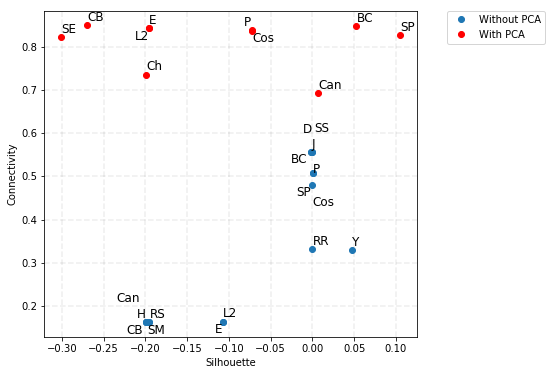

In [393]:
qt.compute_samples_quality(NR=100,Tz=1.65,return_Quality=False,Distance='Spearman',PCA='PCA')
for Tkey in qt.Distmat.keys():
    print Tkey
    for Ikey in qt.AllInternIndex.keys():
        try:
            #Compute the clustering index score
            if Ikey!='log10CalinskiHarabaz':
                print '\t' + Ikey
                labels_C = qt.labels[qt.IdxGoodSamples].copy()
                labels_C_tmp = labels_C.copy()
                for i,l in enumerate(np.unique(labels_C)):
                    labels_C_tmp[labels_C==l] = i
                labels_C = labels_C_tmp

                dist = qt.Distmat[Tkey][np.ix_(qt.IdxGoodSamples,qt.IdxGoodSamples)].copy()
                qt.Res[Ikey][Tkey] = qt.AllInternIndex[Ikey](dist,labels_C)
        except Exception as e:
            print(e)
            continue
            

qt.displayNamesScatter(Suffix='_scATACCont_PCA_all_Zscore_1.65',ImgSize=6,numdisplay=-1,dispNoPCA=True,dispPCA=True)

In [481]:
import pandas as pd

CIlabels = qt.labels[qt.IdxGoodSamples].copy()
CIlabels_tmp = CIlabels.copy()
for i,l in enumerate(np.unique(CIlabels)):
    CIlabels_tmp[labels_C==l] = i
CIlabels = CIlabels_tmp

CIDist = {'Connectivity_low':{},'Connectivity_high':{}}

CIDist['Connectivity_low'] = {     'Silhouette_low':qt.Distmat['None-Hamming-None'][np.ix_(qt.IdxGoodSamples,qt.IdxGoodSamples)].copy(),
                                   'Silhouette_high':qt.Distmat['None-Yule-None'][np.ix_(qt.IdxGoodSamples,qt.IdxGoodSamples)].copy()
                             }
CIDist['Connectivity_high'] = {    'Silhouette_low':qt.Distmat['PCA-Euclidean-None'][np.ix_(qt.IdxGoodSamples,qt.IdxGoodSamples)].copy(),
                                   'Silhouette_high':qt.Distmat['PCA-Bray Curtis-None'][np.ix_(qt.IdxGoodSamples,qt.IdxGoodSamples)].copy()
                              }

Conns = CIDist.keys()
Silhs = CIDist[CIDist.keys()[0]].keys()

In [490]:
from sklearn.cluster import KMeans,AffinityPropagation
from sklearn.metrics import adjusted_rand_score

K = np.max(CIlabels)+1

pd_kmeans = pd.DataFrame(index=Silhs, columns=Conns)
pd_AP = pd.DataFrame(index=Silhs, columns=Conns)
for silh in Silhs:
    print silh
    for conn in Conns:
        print '\t'+conn
        Klabels = KMeans(n_clusters=K, random_state=0).fit_predict(CIDist[conn][silh])
        pd_kmeans.loc[silh][conn] = adjusted_rand_score(CIlabels,Klabels)
        
print pd_kmeans

Silhouette_low
	Connectivity_high
	Connectivity_low
Silhouette_high
	Connectivity_high
	Connectivity_low
                Connectivity_high Connectivity_low
Silhouette_low          0.0229285        0.0195392
Silhouette_high          0.198028         0.193682


In [499]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score

K = np.max(CIlabels)+1

params =      {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 20,
                'n_clusters': K}

# ============
# Create cluster objects
# ============
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',affinity='precomputed')
dbscan = cluster.DBSCAN(eps=params['eps'],metric='precomputed')
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], affinity='precomputed')
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity='precomputed',
    n_clusters=params['n_clusters'])
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')
kmeans = cluster.KMeans(n_clusters=params['n_clusters'], random_state=0)

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('SpectralClustering', spectral),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm),
    ('Kmeans', kmeans)
)
Scores = {}
for name, algorithm in clustering_algorithms:
    print '\t'+name
    Scores[name] = pd.DataFrame(index=Silhs, columns=Conns)

    for silh in Silhs:
        #print '\t'+silh
        for conn in Conns:
            #print '\t\t'+conn
            X = CIDist[conn][silh]

            algorithm.fit(X)

            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            Scores[name].loc[silh][conn] = adjusted_mutual_info_score(CIlabels,y_pred)
    print Scores[name]

	MiniBatchKMeans
                Connectivity_high Connectivity_low
Silhouette_low          0.0278444        0.0165533
Silhouette_high          0.154098         0.161866
	AffinityPropagation
                Connectivity_high Connectivity_low
Silhouette_low       -0.000261811        0.0542021
Silhouette_high         0.0370733      -0.00783216
	SpectralClustering
                Connectivity_high Connectivity_low
Silhouette_low         0.00312058       0.00266451
Silhouette_high        0.00704158        0.0098276
	AgglomerativeClustering
                Connectivity_high Connectivity_low
Silhouette_low         0.00227598       0.00151388
Silhouette_high          0.167373       0.00246348
	DBSCAN
                Connectivity_high Connectivity_low
Silhouette_low                  0                0
Silhouette_high         0.0194882     -0.000394596
	Birch
                Connectivity_high Connectivity_low
Silhouette_low          0.0257201                0
Silhouette_high           0.20304  

In [561]:
Scores['AgglomerativeClustering'].to_latex()

u'\\begin{tabular}{lll}\n\\toprule\n{} & Connectivity\\_high & Connectivity\\_low \\\\\n\\midrule\nSilhouette\\_low  &        0.00227598 &       0.00151388 \\\\\nSilhouette\\_high &          0.167373 &       0.00246348 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [562]:
Scores['Kmeans'].to_latex()

u'\\begin{tabular}{lll}\n\\toprule\n{} & Connectivity\\_high & Connectivity\\_low \\\\\n\\midrule\nSilhouette\\_low  &         0.0229285 &        0.0195392 \\\\\nSilhouette\\_high &          0.198028 &         0.193682 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [563]:
Scores['GaussianMixture'].to_latex()

u'\\begin{tabular}{lll}\n\\toprule\n{} & Connectivity\\_high & Connectivity\\_low \\\\\n\\midrule\nSilhouette\\_low  &         0.0229285 &        0.0205281 \\\\\nSilhouette\\_high &          0.198028 &         0.193682 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Understanding the impact of Silhouette and Connectivity on MDS and t-SNE

In [538]:
from sklearn.manifold import MDS,TSNE
from tqdm import tqdm
K = np.max(CIlabels)+1
dict_MDS = {conn:{} for conn in Conns}
#dict_TSNE = {conn:{} for conn in Conns}

#tsne = TSNE(n_components=2, random_state=3,early_exaggeration=4.0, perplexity=10,learning_rate=10,n_iter=100000, metric='precomputed')
mds = MDS(dissimilarity='precomputed',n_init=10, max_iter=1000)
for silh in tqdm(Silhs,desc='Silhouette'):
    for conn in tqdm(Conns,desc='Connectivity'):
        dict_MDS[conn][silh] = mds.fit_transform(CIDist[conn][silh])
        #dict_TSNE[conn][silh] = tsne.fit_transform(CIDist[conn][silh])


Silhouette: 100%|██████████| 2/2 [07:59<00:00, 239.96s/it]


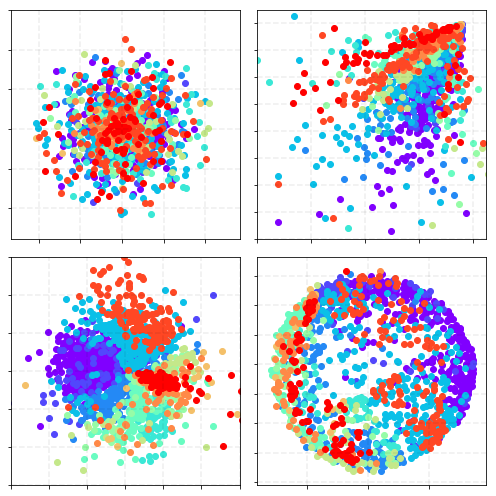

In [559]:
from matplotlib.pyplot import cm

color=cm.rainbow(np.linspace(0,1,np.max(CIlabels)+1))
for XY in [dict_MDS]:
    f,ax = plt.subplots(2,2,figsize=(7,7))
    for i,silh in enumerate(Silhs):
        for j,conn in enumerate(Conns[::-1]):
            for l in range(np.max(CIlabels)+1):
                ax[i,j].scatter(XY[conn][silh][CIlabels==l,0],XY[conn][silh][CIlabels==l,1],c=color[l],label=namesCT[l])


            #ax[i,j].set_title(silh+'\t'+conn)
            ax[i,j].grid(color='k',linestyle='--',linewidth=0.1)
            ax[i,j].set_xticklabels([])
            ax[i,j].set_yticklabels([])
    
    #lgd = ax[0,0].legend(bbox_to_anchor=(2.3, 1), loc=2, borderaxespad=0.)
    
    ax[0,1].set_xlim([-60,25])
    ax[0,1].set_ylim([-60,25])
    
    ax[1,0].set_xlim([-0.3,0.3])
    ax[1,0].set_ylim([-0.3,0.3])
    plt.tight_layout()
    plt.savefig('Comp_MDS_Silh_Conn.png',dpi=300)
    plt.show()

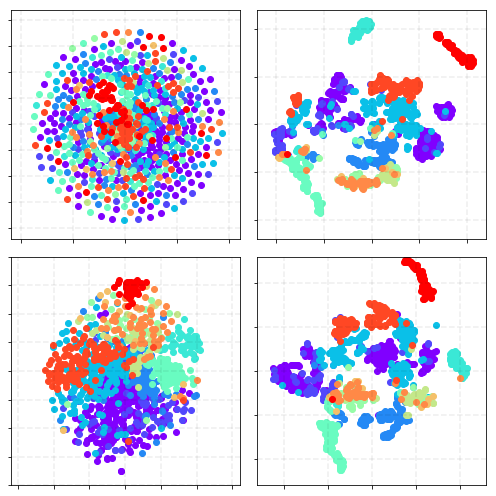

In [560]:
from matplotlib.pyplot import cm

color=cm.rainbow(np.linspace(0,1,np.max(CIlabels)+1))
for XY in [dict_TSNE]:
    f,ax = plt.subplots(2,2,figsize=(7,7))
    for i,silh in enumerate(Silhs):
        for j,conn in enumerate(Conns[::-1]):
            for l in range(np.max(CIlabels)+1):
                ax[i,j].scatter(XY[conn][silh][CIlabels==l,0],XY[conn][silh][CIlabels==l,1],c=color[l],label=namesCT[l])


            #ax[i,j].set_title(silh+' | '+conn)
            ax[i,j].grid(color='k',linestyle='--',linewidth=0.1)
            ax[i,j].set_xticklabels([])
            ax[i,j].set_yticklabels([])

    #lgd = ax[0,0].legend(bbox_to_anchor=(2.3, 1), loc=2, borderaxespad=0.)
    
    ax[0,1].set_xlim([-120,120])
    ax[0,1].set_ylim([-120,120])
    ax[0,0].set_xlim([-11,11])
    ax[0,0].set_ylim([-11,11])
    ax[1,1].set_xlim([-130,130])
    ax[1,1].set_ylim([-130,130])
    ax[1,0].set_xlim([-8,8])
    ax[1,0].set_ylim([-8,8])
    plt.tight_layout()
    plt.savefig('Comp_TSNE_Silh_Conn.png',dpi=300)
    plt.show()